##Loading...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import platform

print(platform.platform())
#osa
!cat /etc/issue.net
# 메모리 사양
!cat /proc/meminfo

Linux-5.10.147+-x86_64-with-glibc2.29
Ubuntu 20.04.5 LTS
MemTotal:       53477432 kB
MemFree:        48942168 kB
MemAvailable:   51813724 kB
Buffers:          364384 kB
Cached:          2938424 kB
SwapCached:            0 kB
Active:           541768 kB
Inactive:        3668300 kB
Active(anon):        888 kB
Inactive(anon):   879380 kB
Active(file):     540880 kB
Inactive(file):  2788920 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:             56004 kB
Writeback:             0 kB
AnonPages:        908416 kB
Mapped:           273236 kB
Shmem:              1224 kB
KReclaimable:      99904 kB
Slab:             146364 kB
SReclaimable:      99904 kB
SUnreclaim:        46460 kB
KernelStack:        7072 kB
PageTables:        19656 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    26738716 kB
Committed_AS:    3644568 kB
VmallocTotal:   34359738367 kB
VmallocUsed:    

In [ ]:
import pandas as pd
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from tqdm import tqdm
import argparse
import glob
import xml.etree.ElementTree as ET 
import cv2
import ast
import numpy as np


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

import random

import torch
# pytorch 설치 
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from tqdm.notebook import tqdm

#사이킷런으로 train/test 분류류
from sklearn.model_selection import train_test_split

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


import warnings
warnings.filterwarnings("ignore")

In [ ]:
# !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

## Generate CSV

In [ ]:
path_an = "/content/drive/MyDrive/pcb_data/PCB_DATASET/Annotations"
print(path_an)

/content/drive/MyDrive/pcb_data/PCB_DATASET/Annotations


In [ ]:
# x,y 최소 최대 높이 넓이 데이터셋 요소(딕셔너리 형태)
dataset = {
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
            "class":[],    
            "file":[],
            "width":[],
            "height":[],
           }
all_files = []
for path, subdirs, files in os.walk(path_an):
#     print([path, subdirs, files])
    for name in files:
        all_files.append(os.path.join(path, name))

# print(all_files)       
print(type(dataset))
print(dataset)

<class 'dict'>
{'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'class': [], 'file': [], 'width': [], 'height': []}


In [ ]:
for anno in all_files:
    # print(anno)
    #element tree parsing
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        # print(elem)
        #parsing 후 size가 있고 width, height가 있으면 text를 반올림 한다
        if 'size' in elem.tag:
            # print('[size] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            # print('[object] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                
                # print('attr = %s\n' % attr)
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['class']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 
                # 최소,최대 조건을 더해준다.
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]         

In [ ]:
data=pd.DataFrame(dataset)
data

,xmin,ymin,xmax,ymax,class,file,width,height
0,1018,413,1072,508,spurious_copper,09_spurious_copper_04,2775,2159
1,2543,918,2627,994,spurious_copper,09_spurious_copper_04,2775,2159
2,1382,977,1530,1030,spurious_copper,09_spurious_copper_04,2775,2159
3,2281,423,2381,472,spurious_copper,09_spurious_copper_04,2775,2159
4,559,741,618,874,spurious_copper,09_spurious_copper_04,2775,2159
...,...,...,...,...,...,...,...,...
2948,899,353,1003,427,short,07_short_01,2904,1921
2949,398,622,539,731,short,07_short_01,2904,1921
2950,1229,869,1310,955,short,07_short_01,2904,1921
2951,1863,924,1961,1012,short,07_short_01,2904,1921


In [ ]:
img_id=data["file"].unique()
train_id, test_id = train_test_split(img_id, shuffle=True, test_size=0.2, random_state=40)

In [ ]:
print(len(train_id),len(test_id))


554 139


In [ ]:
train_df = data[data['file'].isin(train_id)]
train_df

,xmin,ymin,xmax,ymax,class,file,width,height
5,1142,389,1236,435,spurious_copper,10_spurious_copper_05,2240,2016
6,1434,834,1519,880,spurious_copper,10_spurious_copper_05,2240,2016
7,1719,1022,1759,1121,spurious_copper,10_spurious_copper_05,2240,2016
8,907,771,1010,821,spurious_copper,10_spurious_copper_05,2240,2016
9,1237,874,1291,992,spurious_copper,10_spurious_copper_05,2240,2016
...,...,...,...,...,...,...,...,...
2948,899,353,1003,427,short,07_short_01,2904,1921
2949,398,622,539,731,short,07_short_01,2904,1921
2950,1229,869,1310,955,short,07_short_01,2904,1921
2951,1863,924,1961,1012,short,07_short_01,2904,1921


In [ ]:
test_df = data[data['file'].isin(test_id)]
test_df

,xmin,ymin,xmax,ymax,class,file,width,height
0,1018,413,1072,508,spurious_copper,09_spurious_copper_04,2775,2159
1,2543,918,2627,994,spurious_copper,09_spurious_copper_04,2775,2159
2,1382,977,1530,1030,spurious_copper,09_spurious_copper_04,2775,2159
3,2281,423,2381,472,spurious_copper,09_spurious_copper_04,2775,2159
4,559,741,618,874,spurious_copper,09_spurious_copper_04,2775,2159
...,...,...,...,...,...,...,...,...
2933,1713,584,1795,643,short,12_short_01,2529,2530
2934,1197,1834,1253,1915,short,12_short_01,2529,2530
2935,615,2237,695,2312,short,12_short_01,2529,2530
2936,266,1134,366,1210,short,12_short_01,2529,2530


In [ ]:
train_df.shape, test_df.shape

((2352, 8), (601, 8))

In [ ]:
# PCB 분류
classes_la = {"missing_hole": 0, "mouse_bite": 1, "open_circuit":2, "short": 3, 'spur': 4,'spurious_copper':5}
train_df["class"] = train_df["class"].apply(lambda x: classes_la[x])
test_df["class"] = test_df["class"].apply(lambda x: classes_la[x])

### 간단하게 출력해서 살펴보기

In [ ]:
# 파일 이미지 그리기
# .. 입력: image_name(이미지 파일명) //'01_missing_hole_01', '12_spurious_copper_06', ..
def plot_image(df,image_name):
    print(image_name)
    df=df.groupby(['file'])
    image_group = df.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    path ="/content/drive/MyDrive/pcb_data/PCB_DATASET/images/"
    if "missing" in name.split('_'):
        path += 'Missing_hole/'
    if "mouse" in name.split('_'):
        path += 'Mouse_bite/'
    if "open" in name.split('_'):
        path += 'Open_circuit/'
    if "short" in name.split('_'):
        path += 'Short/'
    if "spur" in name.split('_'):
        path += 'Spur/'
    if "spurious" in name.split('_'):
        path += 'Spurious_copper/'
   
    img = immg.imread(path+""+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(box)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        # ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

11_open_circuit_05
[752 124 809 186]
[ 970  383 1025  435]
[1509  970 1573 1053]
[ 624 1160  683 1229]
[1080 1467 1137 1526]


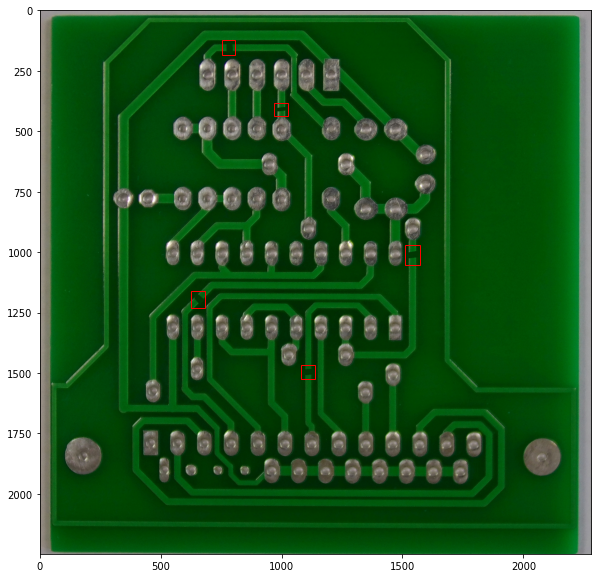

In [ ]:
name = test_id[0]
plot_image(test_df,name)

## Custom Dataset
=

In [ ]:
def get_train_basic_transform():
    return A.Compose([
       
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})



def get_test_transform():
    return A.Compose([
        
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
# pytorch전용
# Custom Dataset 클래스 생성 (https://visionhong.tistory.com/4?category=946616)
# .. (1) torch.utils.data.Dataset을 오버라이드
# .. (2) 3개 함수 필수 구현: __init__, __len__, __getitem__
# -----------------
# 인덱스로 접근할 수 있는 이터레이터 (https://dojang.io/mod/page/view.php?id=2407)
# .. (1) 클래스에서 __getitem__ 메서드만 구현해도 이터레이터가 되며 __iter__, __next__는 생략해도 됨
# .. (2) 클래스에서 __getitem__ 메서드를 구현하면 인덱스로 접근할 수 있는 이터레이터가 됨
#

#df는 annotation을 저장하고 있는 데이터셋.


class fcbData(object):
    def __init__(self, df, IMG_DIR, transforms): 
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['file'].unique().tolist() #각 파일 이름을 list로 구성.
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        a = ''
        if "missing" in image_id.split('_'):
            a = 'Missing_hole/'
        elif "mouse" in image_id.split('_'):
            a = 'Mouse_bite/'
        elif "open" in image_id.split('_'):
            a = 'Open_circuit/'
        elif "short" in image_id.split('_'):
            a = 'Short/'
        elif "spur" in image_id.split('_'):
            a = 'Spur/'
        elif "spurious" in image_id.split('_'):
            a = 'Spurious_copper/'
        image_values = self.df[self.df['file'] == image_id]
        image = cv2.imread(self.img_dir+a+image_id+".jpg",cv2.IMREAD_COLOR)
        # BGR TO RGB --> matplotlib 으로 화면에 출력하는 방법 to 32 bit
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        labels = image_values["class"].values
        labels = torch.tensor(labels)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(len(classes_la), dtype=torch.int64)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
        
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return torch.tensor(image), target, image_id

In [ ]:
df=train_df.copy()

In [ ]:
# df는 'df = train.Copy()' (즉, train data의 deep 복사본)
path ="/content/drive/MyDrive/pcb_data/PCB_DATASET/images/"
fcb_dataset = fcbData(df, path, get_train_basic_transform())


In [ ]:
type(fcb_dataset[0]), len(fcb_dataset[0]), type(fcb_dataset[0][0]), type(fcb_dataset[0][1]), type(fcb_dataset[0][2])

(tuple, 3, torch.Tensor, dict, str)

In [ ]:
# fcb_dataset[i]는 tuple이므로 배열 인덱스로 참조해야 함
# .. tuple인 이유는: __get_item__() 함수의 반환값이 튜플이기 때문 (return torch.tensor(image), target, image_id)
# .. tuple의 원소 참조
# .... [i][0]: image
# .... [i][1]: target    //딕셔너리 {boxes, labels, image_id(인덱스 번호), area, iscrowd}
# .... [i][2]: image_id  //이미지 명칭
print([fcb_dataset[0][0], fcb_dataset[0][1], fcb_dataset[0][2]])

[tensor([[[0.6157, 0.6235, 0.6196,  ..., 0.6235, 0.6275, 0.6353],
         [0.6078, 0.6157, 0.6118,  ..., 0.6235, 0.6196, 0.6275],
         [0.6078, 0.6118, 0.6118,  ..., 0.6157, 0.6078, 0.6118],
         ...,
         [0.6000, 0.5922, 0.6039,  ..., 0.6000, 0.5961, 0.5882],
         [0.6078, 0.5922, 0.5961,  ..., 0.6039, 0.6039, 0.6000],
         [0.6118, 0.5961, 0.5961,  ..., 0.6039, 0.6118, 0.6157]],

        [[0.5922, 0.6000, 0.5961,  ..., 0.6000, 0.6039, 0.6118],
         [0.5843, 0.5922, 0.5882,  ..., 0.6000, 0.5961, 0.6039],
         [0.5843, 0.5882, 0.5882,  ..., 0.5922, 0.5843, 0.5882],
         ...,
         [0.5765, 0.5686, 0.5804,  ..., 0.5922, 0.5882, 0.5804],
         [0.5843, 0.5686, 0.5725,  ..., 0.5961, 0.5961, 0.5922],
         [0.5882, 0.5725, 0.5725,  ..., 0.5961, 0.6039, 0.6078]],

        [[0.6078, 0.6157, 0.6118,  ..., 0.6157, 0.6196, 0.6275],
         [0.6000, 0.6078, 0.6039,  ..., 0.6157, 0.6118, 0.6196],
         [0.6000, 0.6039, 0.6039,  ..., 0.6078, 0.6000, 0

## DataLoader


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataset = fcbData(train_df, path, get_train_basic_transform())


#valid_dataset = fcbData(valid_df, path, get_valid_transform())
test_dataset = fcbData(test_df, path, get_test_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# valid_data_loader = DataLoader(
#     valid_dataset,
#     batch_size=1,
#     shuffle=False,
#     num_workers=4,
#     collate_fn=collate_fn
# )

test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
    collate_fn=collate_fn
)

In [ ]:
next(iter(train_data_loader))

((tensor([[[0.6157, 0.6235, 0.6196,  ..., 0.6235, 0.6275, 0.6353],
           [0.6078, 0.6157, 0.6118,  ..., 0.6235, 0.6196, 0.6275],
           [0.6078, 0.6118, 0.6118,  ..., 0.6157, 0.6078, 0.6118],
           ...,
           [0.6000, 0.5922, 0.6039,  ..., 0.6000, 0.5961, 0.5882],
           [0.6078, 0.5922, 0.5961,  ..., 0.6039, 0.6039, 0.6000],
           [0.6118, 0.5961, 0.5961,  ..., 0.6039, 0.6118, 0.6157]],
  
          [[0.5922, 0.6000, 0.5961,  ..., 0.6000, 0.6039, 0.6118],
           [0.5843, 0.5922, 0.5882,  ..., 0.6000, 0.5961, 0.6039],
           [0.5843, 0.5882, 0.5882,  ..., 0.5922, 0.5843, 0.5882],
           ...,
           [0.5765, 0.5686, 0.5804,  ..., 0.5922, 0.5882, 0.5804],
           [0.5843, 0.5686, 0.5725,  ..., 0.5961, 0.5961, 0.5922],
           [0.5882, 0.5725, 0.5725,  ..., 0.5961, 0.6039, 0.6078]],
  
          [[0.6078, 0.6157, 0.6118,  ..., 0.6157, 0.6196, 0.6275],
           [0.6000, 0.6078, 0.6039,  ..., 0.6157, 0.6118, 0.6196],
           [0.6000, 0.

In [ ]:
next(iter(test_data_loader))

((tensor([[[0.6314, 0.6157, 0.6314,  ..., 0.6235, 0.6157, 0.6078],
           [0.6118, 0.6000, 0.6196,  ..., 0.6157, 0.6157, 0.6157],
           [0.6039, 0.5961, 0.6157,  ..., 0.6118, 0.6118, 0.6196],
           ...,
           [0.6314, 0.6157, 0.6118,  ..., 0.6118, 0.6157, 0.6078],
           [0.6118, 0.6039, 0.6078,  ..., 0.6078, 0.6039, 0.6000],
           [0.5961, 0.5961, 0.6078,  ..., 0.5961, 0.5843, 0.5843]],
  
          [[0.6039, 0.5882, 0.6039,  ..., 0.5843, 0.5765, 0.5686],
           [0.5843, 0.5725, 0.5922,  ..., 0.5765, 0.5765, 0.5765],
           [0.5765, 0.5686, 0.5882,  ..., 0.5725, 0.5725, 0.5804],
           ...,
           [0.5843, 0.5686, 0.5647,  ..., 0.5725, 0.5765, 0.5686],
           [0.5647, 0.5569, 0.5608,  ..., 0.5804, 0.5765, 0.5725],
           [0.5490, 0.5490, 0.5608,  ..., 0.5765, 0.5647, 0.5647]],
  
          [[0.6314, 0.6157, 0.6314,  ..., 0.6196, 0.6118, 0.6039],
           [0.6118, 0.6000, 0.6196,  ..., 0.6118, 0.6118, 0.6118],
           [0.6039, 0.

In [ ]:
## num_classes = 6 # + background
num_classes = 7
# load a model; pre-trained on COCO
# .. fpn = 'feature pyramid network'
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)


# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


  0%|          | 0.00/167M [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#
# [PyTorch tutorial] PyTorch에서 GPU 활용하기 (https://wonder-j.tistory.com/12)
# .. (1) PyTorch에서 GPU를 활용하는 법은 간단하다. "모델을 GPU에 넣어주면 됨"
#        device = torch.device("cuda:0")
#        model.to(device)
# .. (2) 모든 텐서를 GPU에 넣어줌(input, lable 등)
#        mytensor = my_tensor.to(device)
#
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005,)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
num_epochs = 10

## Train & Evaluate

In [ ]:
import sys
best_epoch = 0
min_loss = sys.maxsize

for epoch in range(num_epochs):
    tk = tqdm(train_data_loader)
    model.train();
    for images, targets, image_ids in tk:
      # 모든 모듈의 매개변수와 버퍼를 CUDA tensor로 변경
        images = list(image.to(device) for image in images) 
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        tk.set_postfix(train_loss=loss_value)
    tk.close()

    
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    print(f"Epoch #{epoch} loss: {loss_value}") 
        
    #validation 
    model.eval();
    with torch.no_grad():
        tk = tqdm(test_data_loader)
        for images, targets, image_ids in tk:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            val_output = model(images)
            val_output = [{k: v.to(device) for k, v in t.items()} for t in val_output]
            IOU = []
            for j in range(len(val_output)):
                a,b = val_output[j]['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                chk = torchvision.ops.box_iou(a,b)
                res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                IOU.append(res)
            tk.set_postfix(IoU=np.mean(IOU))
        tk.close()

  0%|          | 0/554 [00:00<?, ?it/s]

Epoch #0 loss: 0.39116549885062574


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/554 [00:00<?, ?it/s]

Epoch #1 loss: 0.2919203063269641


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/554 [00:00<?, ?it/s]

Epoch #2 loss: 0.37287860415210466


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/554 [00:00<?, ?it/s]

Epoch #3 loss: 0.27665475272105805


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/554 [00:00<?, ?it/s]

Epoch #4 loss: 0.23572959481603142


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/554 [00:00<?, ?it/s]

Epoch #5 loss: 0.19375290145853788


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/554 [00:00<?, ?it/s]

Epoch #6 loss: 0.24411884489719024


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/554 [00:00<?, ?it/s]

Epoch #7 loss: 0.248446637807026


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/554 [00:00<?, ?it/s]

Epoch #8 loss: 0.20220620261308528


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/554 [00:00<?, ?it/s]

Epoch #9 loss: 0.22568199964831284


  0%|          | 0/139 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), 'pcbdetection1.pt')

In [ ]:
y_true =[]
y_pred = []
score=[]
box=[]
for i in range(50):
  if(test_dataset[i]==0):
      continue
  else:
    img,target,_ = test_dataset[i]
    model.eval() 
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
        #print(prediction['labels'])
        if(len(prediction['labels'])==0):
          continue
        else:
          box.append(prediction['boxes'][0])
          y_true.append(target['labels'][0])
          y_pred.append(prediction['labels'][0])
          score.append(prediction['scores'][0]) 



In [ ]:
yy_pred = []

# cpu작업을 통한 메모리 활당
for v in y_pred:
    yy_pred.append(v.cpu())

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, yy_pred)

array([[ 0, 17,  9,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  1,  0],
       [ 0,  0,  4, 19]])

In [ ]:
# classification_report로 평가 지표 확인하기
# .. https://blog.naver.com/PostView.naver?blogId=hannaurora&logNo=222498671200&parentCategoryNo=&categoryNo=41&viewDate=&isShowPopularPosts=true&from=search
from sklearn.metrics import classification_report
print(classification_report(y_true, yy_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        26
           2       0.00      0.00      0.00         0
           4       0.07      1.00      0.13         1
           5       1.00      0.83      0.90        23

    accuracy                           0.40        50
   macro avg       0.27      0.46      0.26        50
weighted avg       0.46      0.40      0.42        50



## mAP 계산

In [ ]:
truth=[]
for i in range(len(yy_pred)):
  if(yy_pred[i]==y_true[i]):
    truth.append(1)
  else:
    truth.append(0)

In [ ]:
y_score = []

# cpu작업을 통한 메모리 활당
for v in score:
    y_score.append(v.cpu())

In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve

truths = np.array(truth)
scores = np.array(y_score)

ap = average_precision_score(truths, scores)
print('평균 정밀도(AP)는 {}입니다.'.format(ap))

평균 정밀도(AP)는 0.7576710717902669입니다.
